# TOBB ETÜ Yapay Zeka Mühendisliği Bölümü
### YAP 470 / BİL 570 Dönem Projesi 2. Ara Rapor

##### İlbey Efe Taşabatlı
##### 221101026
##### YAP470

# Yüz İfadelerinin Sınıflandırılması ve Gerçek Zamanlı Tahmini

**Açıklama:**
Bu rapor, 'Facial Emotion Recognition Image Dataset' (Kaggle) kullanarak yüz ifadelerini sınıflandırma projesinin
2. Ara Raporudur. Projede uygulanan detaylı Veri Keşfi ve Analizi (EDA), veri ön işleme,
Custom CNN modelinin eğitimi sunulmuştur.

In [2]:
import os
import cv2
import json
import subprocess
import time  # For FPS calculations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, 
    Conv2D, 
    MaxPooling2D, 
    Flatten, 
    Dense, 
    Dropout, 
    BatchNormalization, 
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [8]:
import os
import subprocess
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

BASE_DIR = Path().resolve()

ORIGINAL_DATASET_PATH = BASE_DIR / 'archive' / 'dataset'
PROCESSED_DATASET_PATH = BASE_DIR / 'processed_dataset'
PREPROCESSING_SCRIPT_PATH = BASE_DIR / 'preprocess.py'
MODEL_IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT_RATIO = 0.2
EPOCHS = 50

IS_PROCESSED_AVAILABLE = False
CLASS_NAMES = []
NUM_CLASSES = 0

try:
    CLASS_NAMES = sorted([d for d in os.listdir(ORIGINAL_DATASET_PATH) if os.path.isdir(os.path.join(ORIGINAL_DATASET_PATH, d))])
    if CLASS_NAMES:
        print(f"{len(CLASS_NAMES)} classes found in original dataset.")
except FileNotFoundError:
    print("Original dataset not found. Trying processed dataset...")
    try:
        CLASS_NAMES = sorted([d for d in os.listdir(PROCESSED_DATASET_PATH) if os.path.isdir(os.path.join(PROCESSED_DATASET_PATH, d))])
        if CLASS_NAMES:
            IS_PROCESSED_AVAILABLE = True
            print(f"{len(CLASS_NAMES)} classes found in processed dataset.")
    except FileNotFoundError:
        print("Error: Neither original nor processed dataset found.")

if CLASS_NAMES:
    NUM_CLASSES = len(CLASS_NAMES)
    print(f"Number of classes: {NUM_CLASSES}")
else:
    print("Warning: No classes found.")


print("Step 1: Checking preprocessing status")


if not PROCESSED_DATASET_PATH.exists() or len(os.listdir(PROCESSED_DATASET_PATH)) == 0:
    print("Processed dataset not found or is empty. Running preprocessing script...")

    if not Path(PREPROCESSING_SCRIPT_PATH).exists():
        print(f"Error: Script '{PREPROCESSING_SCRIPT_PATH}' not found.")
    else:
        try:
            result = subprocess.run(
                ['python', PREPROCESSING_SCRIPT_PATH], 
                capture_output=True, 
                text=True, 
                check=True
            )
            print("Preprocessing completed successfully.")
            IS_PROCESSED_AVAILABLE = True
        except FileNotFoundError:
            print("Error: 'python' command not found.")
        except subprocess.CalledProcessError as e:
            print("Error while running preprocessing script.")
            print(e.stderr)
        except Exception as e:
            print(f"Unexpected error: {e}")
else:
    print("Processed dataset already exists. Skipping preprocessing.")
    IS_PROCESSED_AVAILABLE = True


print("Step 2: Reading file paths and labels")


filepaths = []
labels = []
df = pd.DataFrame()

if IS_PROCESSED_AVAILABLE and CLASS_NAMES:
    for class_name in CLASS_NAMES:
        class_path = PROCESSED_DATASET_PATH / class_name
        if class_path.exists() and class_path.is_dir():
            for file in os.listdir(class_path):
                filepaths.append(str(class_path / file))
                labels.append(class_name)

    if filepaths:
        df = pd.DataFrame({'filepath': filepaths, 'label': labels})
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"{len(df)} images loaded and labeled.")
    else:
        print("Warning: No images found in processed dataset.")
else:
    print("Processed data not available or class list is empty.")


print("Step 3: Splitting dataset")


train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

if not df.empty:
    train_val_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])
    train_df, val_df = train_test_split(train_val_df, train_size=0.875, shuffle=True, random_state=42, stratify=train_val_df['label'])

    print(f"Train: {len(train_df)}")
    print(f"Validation: {len(val_df)}")
    print(f"Test: {len(test_df)}")
else:
    print("Error: DataFrame is empty. Cannot split data.")


print("Step 4: Creating data generators")


train_generator = None
validation_generator = None
test_generator = None

if not train_df.empty and NUM_CLASSES > 0:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df, x_col='filepath', y_col='label',
        target_size=MODEL_IMG_SIZE, class_mode='categorical',
        batch_size=BATCH_SIZE, shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df, x_col='filepath', y_col='label',
        target_size=MODEL_IMG_SIZE, class_mode='categorical',
        batch_size=BATCH_SIZE, shuffle=False
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df, x_col='filepath', y_col='label',
        target_size=MODEL_IMG_SIZE, class_mode='categorical',
        batch_size=BATCH_SIZE, shuffle=False
    )


6 classes found in original dataset.
Number of classes: 6
Step 1: Checking preprocessing status
Processed dataset already exists. Skipping preprocessing.
Step 2: Reading file paths and labels
13935 images loaded and labeled.
Step 3: Splitting dataset
Train: 9754
Validation: 1394
Test: 2787
Step 4: Creating data generators
Found 9754 validated image filenames belonging to 6 classes.
Found 1394 validated image filenames belonging to 6 classes.
Found 2787 validated image filenames belonging to 6 classes.


# Exploratory Data Analysis (EDA)


SECTION: Exploratory Data Analysis (EDA)

Using dataset path: C:\Users\Asus Vivobook\Desktop\YAP470\yap470Proje\archive\dataset
Scanning original dataset for EDA...


Scanning 'Surprise': 100%|██████████| 1234/1234 [00:11<00:00, 106.61it/s]


15453 images scanned from original dataset.

--- Class Distribution ---


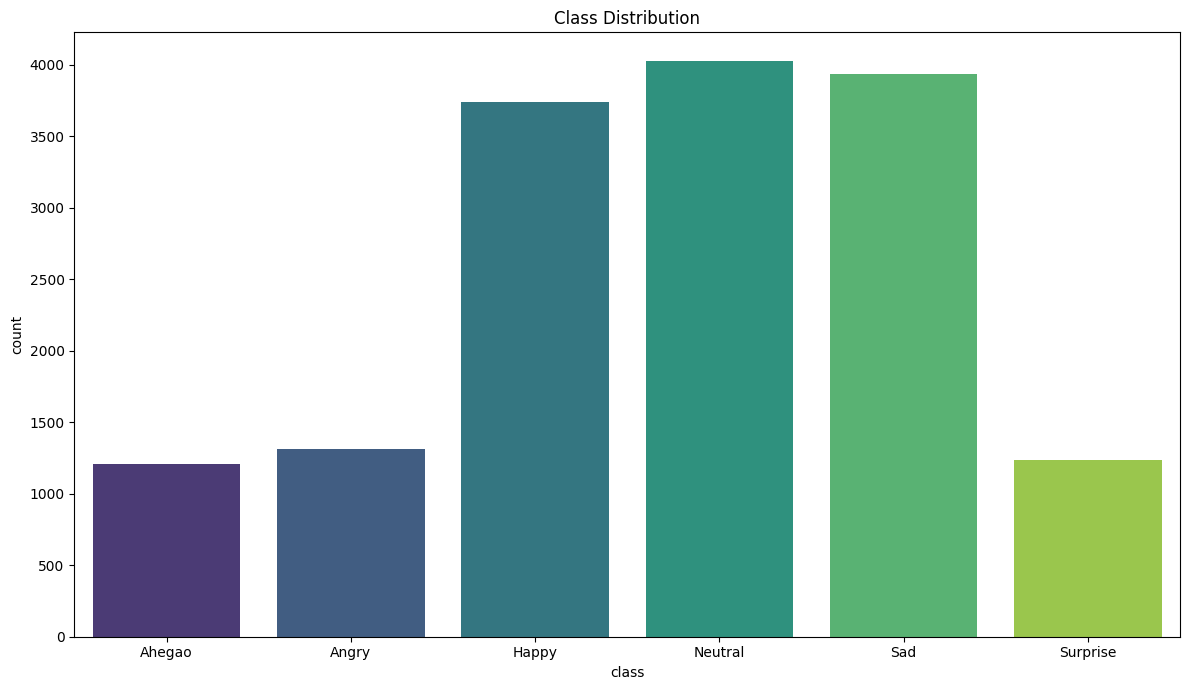


--- Image Dimensions & Aspect Ratio ---


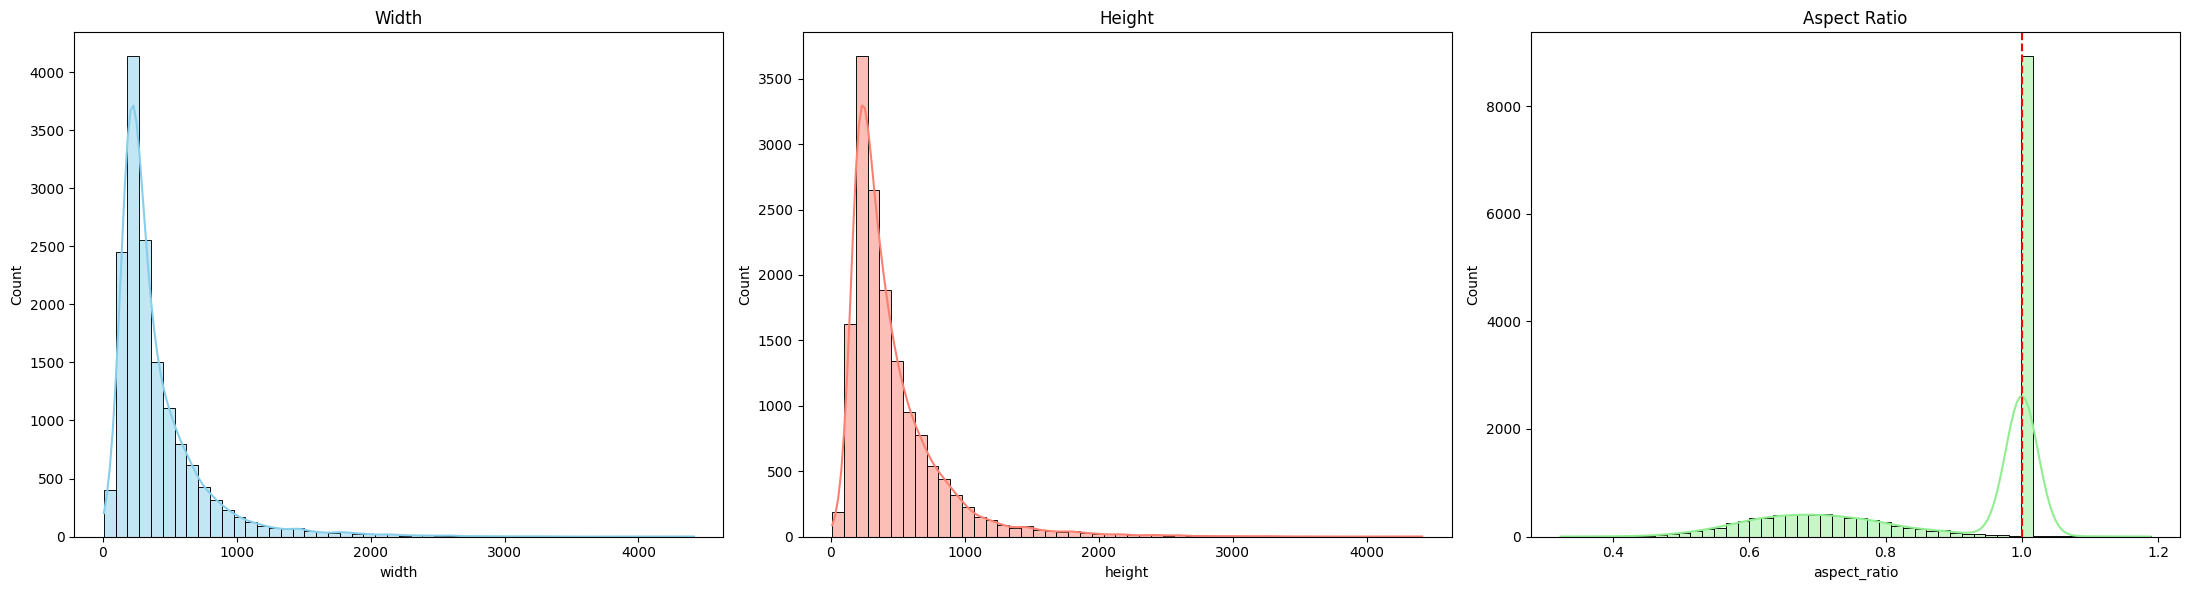


--- Brightness per Class ---


C:\Users\Asus Vivobook\AppData\Local\Temp\ipykernel_19536\2092233004.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_eda, x='class', y='brightness', order=CLASS_NAMES, palette='plasma')


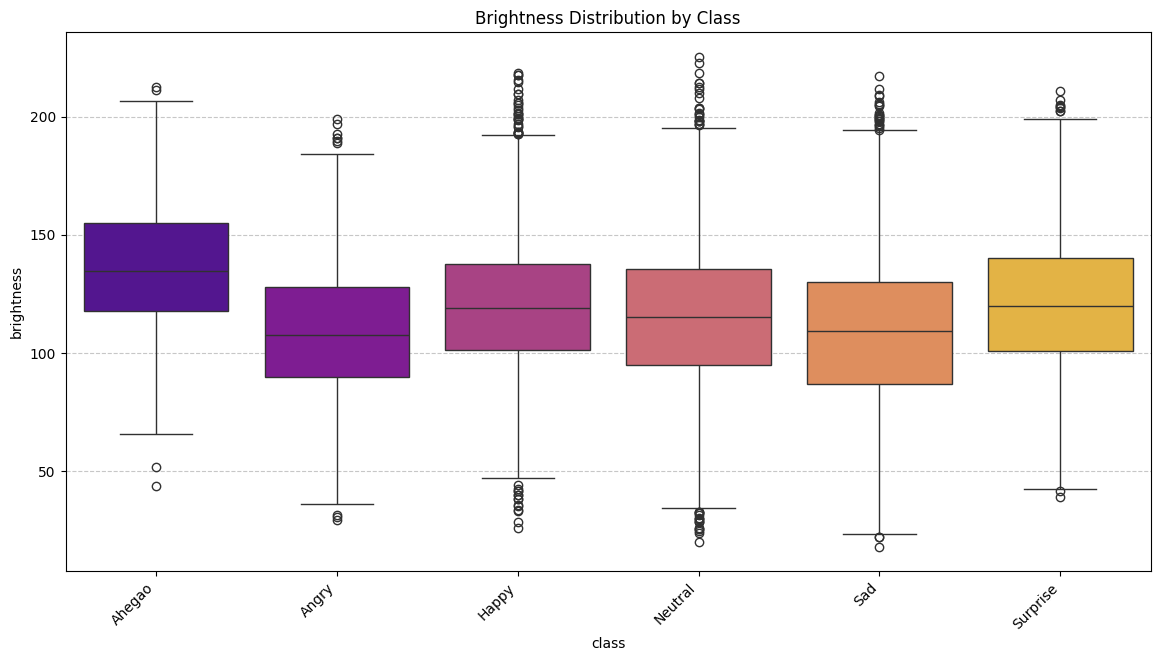


--- Sample Images from Processed Dataset ---


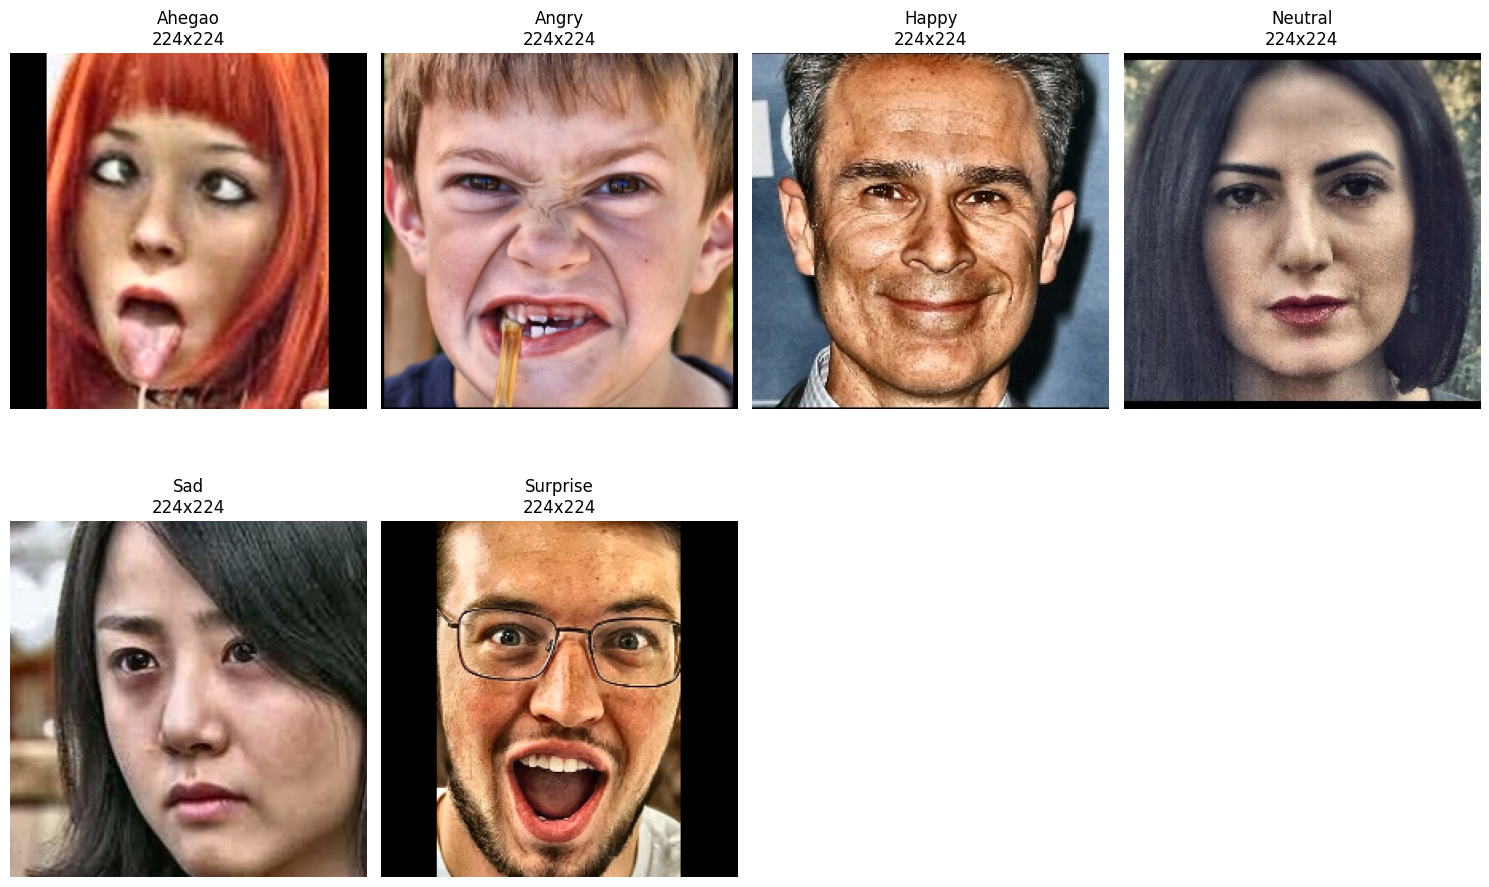


EDA completed.


In [9]:
print("\n" + "="*60)
print("SECTION: Exploratory Data Analysis (EDA)")
print("="*60)

print(f"\nUsing dataset path: {ORIGINAL_DATASET_PATH if ORIGINAL_DATASET_PATH else PROCESSED_DATASET_PATH}")

df_eda = pd.DataFrame()

if ORIGINAL_DATASET_PATH and ORIGINAL_DATASET_PATH.exists():
    print("Scanning original dataset for EDA...")
    eda_data = []
    for class_name in CLASS_NAMES:
        class_path = ORIGINAL_DATASET_PATH / class_name
        for image_name in tqdm(os.listdir(class_path), desc=f"Scanning '{class_name}'"):
            image_path = class_path / image_name
            try:
                img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    height, width = img.shape
                    eda_data.append({
                        "path": str(image_path),
                        "class": class_name,
                        "width": width,
                        "height": height,
                        "aspect_ratio": width / height if height > 0 else 0,
                        "brightness": np.mean(img)
                    })
            except Exception:
                pass
    df_eda = pd.DataFrame(eda_data)
    print(f"\n{len(df_eda)} images scanned from original dataset.")
else:
    print("\nOriginal dataset not found. Using processed dataset for basic analysis.")

if df_eda.empty and IS_PROCESSED_AVAILABLE:
    print("Scanning processed dataset for class distribution...")
    eda_data = []
    for class_name in CLASS_NAMES:
        class_path = PROCESSED_DATASET_PATH / class_name
        for image_name in os.listdir(class_path):
            eda_data.append({"path": str(class_path / image_name), "class": class_name})
    df_eda = pd.DataFrame(eda_data)

if not df_eda.empty:
    print("\n--- Class Distribution ---")
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df_eda, x='class', hue='class', order=CLASS_NAMES, palette='viridis', legend=False)
    plt.title('Class Distribution')
    plt.tight_layout()
    plt.show()

if 'width' in df_eda.columns:
    print("\n--- Image Dimensions & Aspect Ratio ---")
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    sns.histplot(df_eda['width'], bins=50, kde=True, ax=axes[0], color='skyblue').set_title('Width')
    sns.histplot(df_eda['height'], bins=50, kde=True, ax=axes[1], color='salmon').set_title('Height')
    sns.histplot(df_eda['aspect_ratio'], bins=50, kde=True, ax=axes[2], color='lightgreen').set_title('Aspect Ratio')
    axes[2].axvline(1.0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

    print("\n--- Brightness per Class ---")
    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_eda, x='class', y='brightness', order=CLASS_NAMES, palette='plasma')
    plt.title('Brightness Distribution by Class')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("\nOriginal dataset not available. Skipping dimension/brightness analysis.")

print("\n--- Sample Images from Processed Dataset ---")
if IS_PROCESSED_AVAILABLE:
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(CLASS_NAMES):
        try:
            class_path = PROCESSED_DATASET_PATH / class_name
            if len(os.listdir(class_path)) > 0:
                sample_image_name = np.random.choice(os.listdir(class_path))
                sample_image_path = class_path / sample_image_name
                img = cv2.imread(str(sample_image_path))
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax = plt.subplot(2, 4, i + 1 if len(CLASS_NAMES) > 1 else 1)
                plt.imshow(img_rgb)
                plt.title(f"{class_name}\n{img_rgb.shape[1]}x{img_rgb.shape[0]}")
                plt.axis('off')
        except Exception:
            pass
    plt.tight_layout()
    plt.show()
else:
    print("Processed dataset not found. Skipping sample image visualization.")

print("\nEDA completed.")


### Veri Artırma (Data Augmentation) Örnekleri

Derin öğrenme modellerinin genelleştirme yeteneğini artırmak ve aşırı öğrenmeyi (overfitting) azaltmak için veri artırma teknikleri kullanılır. Aşağıda, ImageDataGenerator'ın eğitim sırasında uyguladığı bazı dönüşümlerin örnekleri gösterilmektedir. Bu dönüşümler, modelin farklı yüz pozisyonlarına, ölçeklerine ve ışıklandırma koşullarına daha dayanıklı olmasını sağlar.


SECTION: Data Augmentation Visualization


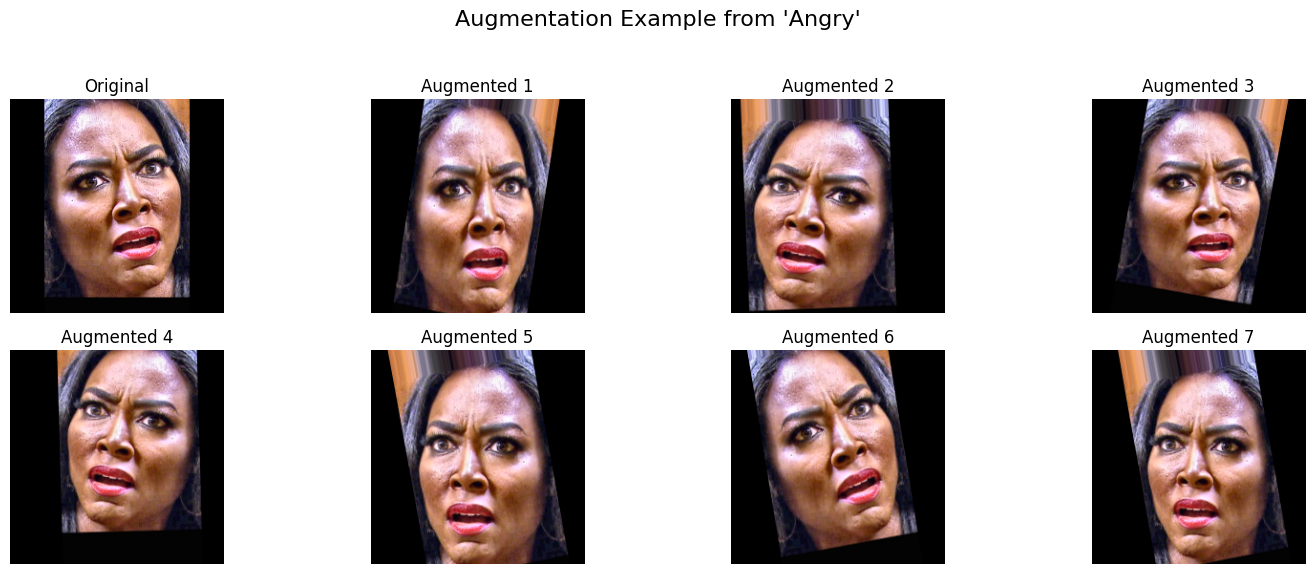

In [37]:
print("\n" + "="*60)
print("SECTION: Data Augmentation Visualization")
print("="*60)

try:
    if 'datagen_with_split' not in locals():
        raise NameError("'datagen_with_split' is not defined. Please run the data preparation cell first.")

    target_path = PROCESSED_DATASET_PATH if IS_PROCESSED_AVAILABLE else ORIGINAL_DATASET_PATH
    non_empty_classes = [c for c in CLASS_NAMES if len(os.listdir(target_path / c)) > 0]

    if not non_empty_classes:
        raise FileNotFoundError("No non-empty class directories found.")

    random_class_name = np.random.choice(non_empty_classes)
    class_path = target_path / random_class_name
    random_image_name = np.random.choice(os.listdir(class_path))
    image_path = class_path / random_image_name

    original_image = cv2.imread(str(image_path))
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    image_for_augmentation = np.expand_dims(original_image_rgb, axis=0)

    aug_iter = datagen_with_split.flow(image_for_augmentation, batch_size=1)

    plt.figure(figsize=(15, 6))
    plt.suptitle(f"Augmentation Example from '{random_class_name}'", fontsize=16)

    plt.subplot(2, 4, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original')
    plt.axis('off')

    for i in range(7):
        plt.subplot(2, 4, i + 2)
        augmented_batch = next(aug_iter)
        augmented_image = augmented_batch[0]
        plt.imshow(augmented_image)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error during augmentation visualization: {e}")


In [38]:
print("\n" + "="*60)
print("SECTION: Data Preprocessing & Generator Setup")
print("="*60)

print("\nInitializing data generators...")

datagen_with_split = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

print("Creating training generator...")
train_generator = datagen_with_split.flow_from_directory(
    PROCESSED_DATASET_PATH,
    target_size=MODEL_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Creating validation generator...")
validation_generator = datagen_with_split.flow_from_directory(
    PROCESSED_DATASET_PATH,
    target_size=MODEL_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = validation_generator

print("\nData generators are ready.")
print(f"Training images: {train_generator.samples}")
print(f"Validation/Test images: {validation_generator.samples}")



SECTION: Data Preprocessing & Generator Setup

Initializing data generators...
Creating training generator...
Found 11150 images belonging to 6 classes.
Creating validation generator...
Found 2785 images belonging to 6 classes.

Data generators are ready.
Training images: 11150
Validation/Test images: 2785


# Model Eğitimi

Bu bölümde, projemizde kullanılan derin öğrenme modellerinin eğitim süreçleri ve değerlendirme metrikleri detaylandırılmıştır. İki ana yöntem, **Özel Evrişimli Sinir Ağı (Custom CNN)** ve **Transfer Öğrenme (MobileNetV2)**, uygulanmış ve performansları karşılaştırılmıştır.

### Yardımcı Fonksiyonlar
Model eğitim ve değerlendirme süreçlerini kolaylaştırmak için kullanılan fonksiyonlar aşağıdadır.

In [39]:
def plot_training_history(history, model_name):
    """
    Plot training and validation loss and accuracy.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model_performance_dl(model, generator, model_name, class_names):
    """
    Evaluate model on test set and plot confusion matrix.
    """
    print(f"\nEvaluating {model_name}...")

    loss, acc = model.evaluate(generator, verbose=1)
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")

    y_pred_probs = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes

    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print("\nClassification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return report, cm


In [41]:
print("\n" + "="*60)
print("METHOD 1: CUSTOM CONVOLUTIONAL NEURAL NETWORK (CNN)")
print("="*60)

def create_custom_cnn_model(input_shape, num_classes):
    """
    Builds a custom CNN model from scratch.
    """
    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Classification
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("\nCreating Custom CNN model...")
custom_cnn_model = create_custom_cnn_model(
    input_shape=(MODEL_IMG_SIZE[0], MODEL_IMG_SIZE[1], 3),
    num_classes=NUM_CLASSES
)

print("Model Summary:")
custom_cnn_model.summary()



METHOD 1: CUSTOM CONVOLUTIONAL NEURAL NETWORK (CNN)

Creating Custom CNN model...
Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 25,981,734 (99.11 MB)

 Trainable params: 25,980,326 (99.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [68]:
# ==============================================================================
# BÖLÜM: CUSTOM CNN MODELİNİN OLUŞTURULMASI VE EĞİTİLMESİ
# ==============================================================================

print("Custom CNN modeli oluşturuluyor ve eğitilecek...")

def create_custom_cnn_model(input_shape, num_classes):
    """
    Sıfırdan bir Evrişimli Sinir Ağı (CNN) modeli oluşturur.
    """
    model = Sequential([
        Input(shape=input_shape),
        # BLOK 1
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # BLOK 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # BLOK 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Sınıflandırma Bloğu
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    # Modeli derleyelim
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Modeli oluşturalım
custom_model = create_custom_cnn_model(
    input_shape=(MODEL_IMG_SIZE[0], MODEL_IMG_SIZE[1], 3),
    num_classes=NUM_CLASSES
)

print("\nModel başarıyla oluşturuldu. Yapısı şöyle:")
custom_model.summary()

# --- Callback'leri Tanımlama ---
print("\nEğitim sırasında kullanılacak callback'ler ayarlanıyor...")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_custom_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]
print("EarlyStopping ve ModelCheckpoint hazır.")

# --- Modeli Eğitme ---
print(f"\nModel eğitilmeye başlanıyor (maksimum {EPOCHS} epoch)...")
print("EarlyStopping sayesinde eğitim daha erken bitebilir.")

history = custom_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\nEğitim tamamlandı!")
print("Model: 'custom_model' değişkeninde.")
print("Eğitim geçmişi: 'history' değişkeninde.")
print("En iyi ağırlıklar 'best_custom_model.h5' dosyasına kaydedildi.")


Custom CNN modeli oluşturuluyor ve eğitilecek...

Model başarıyla oluşturuldu. Yapısı şöyle:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 880,038 (3.36 MB)

 Trainable params: 878,886 (3.35 MB)

 Non-trainable params: 1,152 (4.50 KB)


Eğitim sırasında kullanılacak callback'ler ayarlanıyor...
EarlyStopping ve ModelCheckpoint hazır.

Model eğitilmeye başlanıyor (maksimum 100 epoch)...
EarlyStopping sayesinde eğitim daha erken bitebilir.
Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.2738 - loss: 2.2666

C:\Users\Asus Vivobook\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.27547, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 86s 533ms/step - accuracy: 0.2741 - loss: 2.2646 - val_accuracy: 0.2755 - val_loss: 1.8400
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.4239 - loss: 1.4894
Epoch 2: val_accuracy did not improve from 0.27547
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.4240 - loss: 1.4889 - val_accuracy: 0.2704 - val_loss: 2.0201
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5029 - loss: 1.2516
Epoch 3: val_accuracy improved from 0.27547 to 0.53156, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.5030 - loss: 1.2513 - val_accuracy: 0.5316 - val_loss: 1.1504
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5416 - loss: 1.1264
Epoch 4: val_accuracy improved from 0.53156 to 0.60832, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.5417 - loss: 1.1262 - val_accuracy: 0.6083 - val_loss: 0.9748
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.5650 - loss: 1.0597
Epoch 5: val_accuracy improved from 0.60832 to 0.62626, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 288ms/step - accuracy: 0.5650 - loss: 1.0596 - val_accuracy: 0.6263 - val_loss: 0.8863
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5860 - loss: 1.0036
Epoch 6: val_accuracy improved from 0.62626 to 0.66714, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.5860 - loss: 1.0037 - val_accuracy: 0.6671 - val_loss: 0.8473
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6060 - loss: 0.9677
Epoch 7: val_accuracy did not improve from 0.66714
153/153 ━━━━━━━━━━━━━━━━━━━━ 56s 363ms/step - accuracy: 0.6060 - loss: 0.9677 - val_accuracy: 0.6341 - val_loss: 0.8508
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6259 - loss: 0.9253
Epoch 8: val_accuracy did not improve from 0.66714
153/153 ━━━━━━━━━━━━━━━━━━━━ 45s 296ms/step - accuracy: 0.6259 - loss: 0.9253 - val_accuracy: 0.5581 - val_loss: 1.0473
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6383 - loss: 0.8979
Epoch 9: val_accuracy did not improve from 0.66714
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.6383 - loss: 0.8978 - val_accuracy: 0.6671 - val_loss: 0.8170
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6423 - loss: 0.8956
Epoch 10: 

153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.6430 - loss: 0.8877 - val_accuracy: 0.7166 - val_loss: 0.7305
Epoch 12/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6524 - loss: 0.8474
Epoch 12: val_accuracy did not improve from 0.71664
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.6524 - loss: 0.8473 - val_accuracy: 0.7159 - val_loss: 0.7181
Epoch 13/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6640 - loss: 0.8236
Epoch 13: val_accuracy did not improve from 0.71664
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.6640 - loss: 0.8236 - val_accuracy: 0.7138 - val_loss: 0.6966
Epoch 14/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6779 - loss: 0.7942
Epoch 14: val_accuracy did not improve from 0.71664
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.6780 - loss: 0.7941 - val_accuracy: 0.7052 - val_loss: 0.7157
Epoch 15/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6886 - loss: 0.7756
Epoc

153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 288ms/step - accuracy: 0.7051 - loss: 0.7327 - val_accuracy: 0.7267 - val_loss: 0.6534
Epoch 18/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7121 - loss: 0.7098
Epoch 18: val_accuracy improved from 0.72669 to 0.73171, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 287ms/step - accuracy: 0.7121 - loss: 0.7098 - val_accuracy: 0.7317 - val_loss: 0.7014
Epoch 19/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7177 - loss: 0.7058
Epoch 19: val_accuracy improved from 0.73171 to 0.77188, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.7177 - loss: 0.7058 - val_accuracy: 0.7719 - val_loss: 0.5885
Epoch 20/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7172 - loss: 0.7094
Epoch 20: val_accuracy did not improve from 0.77188
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.7172 - loss: 0.7093 - val_accuracy: 0.7281 - val_loss: 0.6776
Epoch 21/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7179 - loss: 0.6962
Epoch 21: val_accuracy did not improve from 0.77188
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.7179 - loss: 0.6962 - val_accuracy: 0.7410 - val_loss: 0.6155
Epoch 22/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7283 - loss: 0.6914
Epoch 22: val_accuracy did not improve from 0.77188
153/153 ━━━━━━━━━━━━━━━━━━━━ 44s 290ms/step - accuracy: 0.7283 - loss: 0.6913 - val_accuracy: 0.7152 - val_loss: 0.6907
Epoch 23/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7428 - loss: 0.6438
Epoc

153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 283ms/step - accuracy: 0.7716 - loss: 0.5915 - val_accuracy: 0.7783 - val_loss: 0.5615
Epoch 31/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7674 - loss: 0.5755
Epoch 31: val_accuracy improved from 0.77834 to 0.78623, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - accuracy: 0.7674 - loss: 0.5756 - val_accuracy: 0.7862 - val_loss: 0.5349
Epoch 32/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7758 - loss: 0.5748
Epoch 32: val_accuracy did not improve from 0.78623
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - accuracy: 0.7758 - loss: 0.5749 - val_accuracy: 0.7798 - val_loss: 0.5598
Epoch 33/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7737 - loss: 0.5683
Epoch 33: val_accuracy did not improve from 0.78623
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.7736 - loss: 0.5684 - val_accuracy: 0.7669 - val_loss: 0.6077
Epoch 34/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7721 - loss: 0.5782
Epoch 34: val_accuracy improved from 0.78623 to 0.78910, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.7721 - loss: 0.5783 - val_accuracy: 0.7891 - val_loss: 0.5528
Epoch 35/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7674 - loss: 0.5917
Epoch 35: val_accuracy did not improve from 0.78910
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.7674 - loss: 0.5917 - val_accuracy: 0.7281 - val_loss: 0.6740
Epoch 36/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7739 - loss: 0.5739
Epoch 36: val_accuracy improved from 0.78910 to 0.79340, saving model to best_custom_model.h5


153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 284ms/step - accuracy: 0.7739 - loss: 0.5739 - val_accuracy: 0.7934 - val_loss: 0.5633
Epoch 37/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7688 - loss: 0.5786
Epoch 37: val_accuracy did not improve from 0.79340
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.7688 - loss: 0.5786 - val_accuracy: 0.7920 - val_loss: 0.5212
Epoch 38/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7796 - loss: 0.5544
Epoch 38: val_accuracy did not improve from 0.79340
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 281ms/step - accuracy: 0.7796 - loss: 0.5544 - val_accuracy: 0.7561 - val_loss: 0.6408
Epoch 39/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7779 - loss: 0.5615
Epoch 39: val_accuracy did not improve from 0.79340
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 282ms/step - accuracy: 0.7779 - loss: 0.5614 - val_accuracy: 0.7590 - val_loss: 0.6323
Epoch 40/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7901 - loss: 0.5435
Epoc